# 預測caries

模型完整樣子

In [22]:
from ultralytics import YOLO
import os
import cv2

# 設定模型的權重檔路徑
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'

# 設定推理圖像的資料夾路徑
image_folder = 'origin'

# 載入 YOLO 模型
model = YOLO(model_path)

# 執行推理，並指定推理的影像資料夾
# 調整 imgsz 為 1280 以適應你的圖片尺寸，並將 conf 門檻設為 0.15 以保留更多預測結果
results = model.predict(source=image_folder, save=True, imgsz=1280, conf=0.15)

# 設定結果保存的目錄
output_dir = 'results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存結果（預測框、標籤等）
for result in results:
    result.save(output_dir)

# 如果您想要提取並保存預測的框和分類結果
for result in results:
    boxes = result.boxes.xyxy  # 獲取預測框的座標 (xyxy)
    scores = result.boxes.conf  # 信心值
    classes = result.boxes.cls  # 分類結果
    print(f"Boxes: {boxes}, Scores: {scores}, Classes: {classes}")

# 檢查輸入圖片與結果的數量
input_images = os.listdir(image_folder)
print(f"輸入影像數量: {len(input_images)}")
print(f"產生的結果數: {len(results)}")

# 檢查是否有未產生結果的圖片
detected_images = [os.path.basename(result.path) for result in results]
undetected_images = [img for img in input_images if img not in detected_images]
print(f"未偵測到的影像: {undetected_images}")



image 1/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.6741573-260-760_1_2022052768.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Root_canal_filling, 4 Backgrounds, 6915.4ms
image 2/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8304498-273-734_1_2022041847.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 3 Backgrounds, 9535.7ms
image 3/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8355091-269-741_1_2022060118.png: 960x1280 1 Alveolar_bone, 2 Crowns, 1 Dentin, 8 Post_and_cores, 1 Restoration, 5 Root_canal_fillings, 4 Backgrounds, 9234.4ms
image 4/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8421053-22-1236_0_2022052776.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 3 Pulps, 1 Restoration, 3 Backgrounds, 9053.8ms
image 5/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.845815-33-1214_1_2022041830.png: 960x1280 1 Alveol

In [21]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # 載入 matplotlib

# 設定模型的權重檔路徑
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'

# 設定推理圖像的資料夾路徑
image_folder = 'origin'

# 載入 YOLO 模型
model = YOLO(model_path)

# 執行推理，並指定推理的影像資料夾
results = model.predict(source=image_folder, save=False, imgsz=1280, conf=0.15)

# 設定結果保存的目錄
output_dir = 'results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 提取並保存預測的分割遮罩
for result in results:
    original_image = cv2.imread(result.path)

    # 創建一個與原圖同尺寸的黑色填充圖像
    mask_image = np.zeros_like(original_image)

    # 遍歷每個物件的預測結果
    for box, score, cls, mask in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls, result.masks.data):
        if cls == 1:  # 假設 'Caries' 的類別 ID 是 1
            # 將分割遮罩轉換為 NumPy 陣列
            mask_np = mask.cpu().numpy()

            # 將遮罩 resize 成與原始影像相同大小
            mask_resized = cv2.resize(mask_np, (original_image.shape[1], original_image.shape[0]))

            # 將遮罩填充到 mask_image 中
            mask_image[mask_resized > 0.5] = [0, 255, 0]  # 用綠色填充

    # 將處理後的遮罩影像與原圖合併
    combined_image = cv2.addWeighted(original_image, 0.5, mask_image, 0.5, 0)

    # 使用 matplotlib 顯示結果
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))  # 將 BGR 轉換為 RGB
    plt.axis('off')  # 不顯示坐標軸
    plt.show()  # 顯示圖像

    # 保存處理後的影像
    cv2.imwrite(os.path.join(output_dir, os.path.basename(result.path)), combined_image)

# 檢查輸入圖片與結果的數量
input_images = os.listdir(image_folder)
print(f"輸入影像數量: {len(input_images)}")
print(f"產生的結果數: {len(results)}")

# 檢查是否有未產生結果的圖片
detected_images = [os.path.basename(result.path) for result in results]
undetected_images = [img for img in input_images if img not in detected_images]
print(f"未偵測到的影像: {undetected_images}")



image 1/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.6741573-260-760_1_2022052768.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Root_canal_filling, 4 Backgrounds, 5547.3ms
image 2/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8304498-273-734_1_2022041847.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 3 Backgrounds, 6331.6ms
image 3/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8355091-269-741_1_2022060118.png: 960x1280 1 Alveolar_bone, 2 Crowns, 1 Dentin, 8 Post_and_cores, 1 Restoration, 5 Root_canal_fillings, 4 Backgrounds, 8895.2ms
image 4/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8421053-22-1236_0_2022052776.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 3 Pulps, 1 Restoration, 3 Backgrounds, 10178.1ms
image 5/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.845815-33-1214_1_2022041830.png: 960x1280 1 Alveo

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\SSTek\AppData\Local\Temp\ipykernel_20860\720343093.py:6: SyntaxWarning: invalid escape sequence '\s'
  show_img_by_path('runs\segment\predict2\caries-0.6741573-260-760_1_2022052768.png')


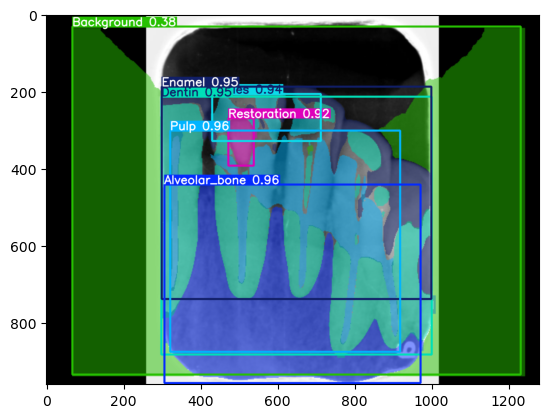

In [7]:
import matplotlib.pyplot as plt
def show_img_by_path(img_path):
    test_img=cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
    plt.imshow(test_img)
    plt.show()
show_img_by_path('runs\segment\predict2\caries-0.6741573-260-760_1_2022052768.png')

In [4]:
# 查看模型標籤
from ultralytics import YOLO

# 載入 YOLOv8 模型
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'
model = YOLO(model_path)

# 查看模型的標籤
labels = model.names
print("Model Labels:\n", labels)


Model Labels:
 {0: 'Alveolar_bone', 1: 'Caries', 2: 'Crown', 3: 'Dentin', 4: 'Enamel', 5: 'Implant', 6: 'Mandibular_alveolar_nerve', 7: 'Maxillary_sinus', 8: 'Periapical_lesion', 9: 'Post_and_core', 10: 'Pulp', 11: 'Restoration', 12: 'Root_canal_filling', 13: 'Background'}


標記蛀牙位置

In [15]:
from ultralytics import YOLO
import os
import cv2  # 載入 OpenCV 用於圖像處理
import numpy as np  # 載入 NumPy 用於數據處理

# 設定模型的權重檔路徑
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'

# 設定推理圖像的資料夾路徑
image_folder = 'origin'
# 載入 YOLO 模型
model = YOLO(model_path)

# 執行推理，並指定推理的影像資料夾
results = model.predict(source=image_folder, save=False, imgsz=640, conf=0.25)

# 設定結果保存的目錄
output_dir = 'result'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 遍歷結果
for result in results:
    # 讀取原始影像
    original_image = cv2.imread(result.path)

    # 遍歷每個物件的預測結果
    for box, score, cls, mask in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls, result.masks.data):
        if cls == 1:  # 'Caries' 的類別 ID 是 1
            # 提取邊界框的座標
            x1, y1, x2, y2 = map(int, box)

            # 將分割遮罩轉換為 NumPy 陣列
            mask_np = mask.cpu().numpy()  # 將 tensor 轉換為 NumPy 陣列

            # 將遮罩 resize 成與原始影像相同大小
            mask_resized = cv2.resize(mask_np, (original_image.shape[1], original_image.shape[0]))

            # 創建一個與原圖同尺寸的紅色填充圖像（用於上色）
            color_mask = np.zeros_like(original_image)
            color_mask[mask_resized > 0.5] = [0, 255, 0]  # 填充綠色

            # 使用 cv2.addWeighted 來混合原始圖像和紅色遮罩，實現半透明效果
            alpha = 0.5  # 設定透明度 (0.5 代表半透明)
            colored_image = cv2.addWeighted(original_image, 1 - alpha, color_mask, alpha, 0)

            # 儲存處理後的影像
            cv2.imwrite(os.path.join(output_dir, os.path.basename(result.path)), colored_image)
            
            # 檢查輸入圖片與結果的數量
            input_images = os.listdir(image_folder)
            print(f"輸入影像數量: {len(input_images)}")
            print(f"產生的結果數: {len(results)}")

            # 檢查是否有未產生結果的圖片
            detected_images = [os.path.basename(result.path) for result in results]
            undetected_images = [img for img in input_images if img not in detected_images]
            print(f"未偵測到的影像: {undetected_images}")



image 1/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.6741573-260-760_1_2022052768.png: 480x640 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Background, 1426.1ms
image 2/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8304498-273-734_1_2022041847.png: 480x640 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Background, 1503.9ms
image 3/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8355091-269-741_1_2022060118.png: 480x640 1 Alveolar_bone, 1 Caries, 1 Crown, 1 Dentin, 1 Maxillary_sinus, 1 Post_and_core, 1 Restoration, 1 Root_canal_filling, 1 Background, 1478.4ms
image 4/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8421053-22-1236_0_2022052776.png: 480x640 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Background, 1323.2ms
image 5/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.845815-33-1214_1_2022041830.png: 480x640 1 Alveolar_bon

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\SSTek\AppData\Local\Temp\ipykernel_20860\3470411208.py:1: SyntaxWarning: invalid escape sequence '\c'
  show_img_by_path('result\caries-0.6741573-260-760_1_2022052768.png')


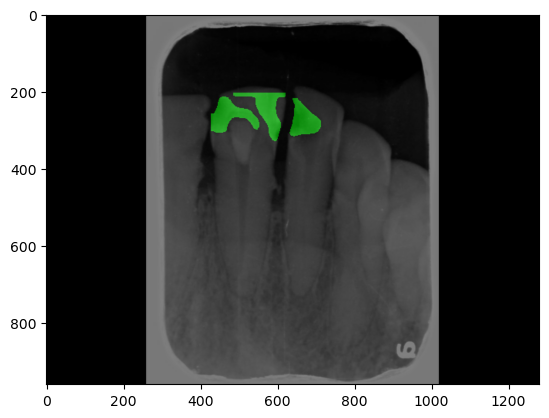

In [8]:
show_img_by_path('result\caries-0.6741573-260-760_1_2022052768.png')

In [14]:
import cv2
import os

# 資料夾路徑
folder1 = 'origin'  # 原圖資料夾
folder2 = 'results_colored'  # 遮罩資料夾
folder3 = 'result'  # 預測遮罩資料夾
output_folder = 'output'  # 輸出資料夾

# 確保輸出資料夾存在
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 獲取資料夾中的圖片名稱列表 (假設圖片名稱相同)
image_filenames = os.listdir(folder1)  # 假設三個資料夾中的圖片名稱都一樣

for filename in image_filenames:
    # 為每張圖片建立完整路徑
    img_path1 = os.path.join(folder1, filename)
    img_path2 = os.path.join(folder2, filename)
    img_path3 = os.path.join(folder3, filename)

    # 讀取圖片
    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)
    img3 = cv2.imread(img_path3)

    # 確保圖片大小一致 (如果大小不一致，可以使用 cv2.resize 調整)
    height, width = img1.shape[:2]
    img2 = cv2.resize(img2, (width, height))
    img3 = cv2.resize(img3, (width, height))

    # 將三張圖片水平拼接
    combined_img = cv2.hconcat([img1, img2, img3])

    # 將拼接後的圖片保存到輸出資料夾
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, combined_img)

print("圖片拼接完成，已保存到:", output_folder)


FileNotFoundError: [Errno 2] No such file or directory: 'result\\caries-0.8510638-270-740_1_2022012069.png'

In [13]:
import cv2
import os

# 輸入資料夾路徑
input_folder = 'origin'

# 輸出資料夾路徑
output_folder = 'results_colored'

# 如果輸出資料夾不存在，則創建
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 瀏覽資料夾中的每張圖片
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # 可以根據需要添加其他圖片格式
        # 完整圖片路徑
        img_path = os.path.join(input_folder, filename)
        
        # 讀取圖片
        image = cv2.imread(img_path)
        
        # 檢查是否成功讀取圖片
        if image is None:
            print(f"無法讀取圖片: {filename}")
            continue
        
        # 將圖片轉換為灰度圖
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 使用Otsu's方法進行二值化處理
        _, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # 保存二值化圖片到輸出資料夾，保持原有的檔名
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, binary_mask)
        print(f"已處理並保存圖片: {output_path}")


已處理並保存圖片: results_colored\caries-0.6741573-260-760_1_2022052768.png
已處理並保存圖片: results_colored\caries-0.8304498-273-734_1_2022041847.png
已處理並保存圖片: results_colored\caries-0.8355091-269-741_1_2022060118.png
已處理並保存圖片: results_colored\caries-0.8421053-22-1236_0_2022052776.png
已處理並保存圖片: results_colored\caries-0.845815-33-1214_1_2022041830.png
已處理並保存圖片: results_colored\caries-0.8480566-272-736_1_2022030481.png
已處理並保存圖片: results_colored\caries-0.8480566-33-1214_0_2022042506.png
已處理並保存圖片: results_colored\caries-0.8510638-268-743_1_2022060601150.png
已處理並保存圖片: results_colored\caries-0.8510638-268-743_1_2022060601151.png
已處理並保存圖片: results_colored\caries-0.8510638-270-740_1_2022012069.png
已處理並保存圖片: results_colored\caries-0.8510638-270-740_1_2022030436.png
已處理並保存圖片: results_colored\caries-0.8510638-270-740_1_2022030743.png
已處理並保存圖片: results_colored\caries-0.8510638-271-738_0_2022060601156.png
已處理並保存圖片: results_colored\caries-0.8510638-271-738_1_2021102004.png
已處理並保存圖片: results_colored\caries-0.85106

In [23]:
from ultralytics import YOLO
import os
import cv2  # 載入 OpenCV 用於圖像處理
import numpy as np  # 載入 NumPy 用於數據處理

# 設定模型的權重檔路徑
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'

# 設定推理圖像的資料夾路徑
image_folder = 'origin'
# 載入 YOLO 模型
model = YOLO(model_path)

# 執行推理，並指定推理的影像資料夾
results = model.predict(source=image_folder, save=False, imgsz=640, conf=0.25)

# 設定結果保存的目錄
output_dir = 'result'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 遍歷結果
for result in results:
    # 讀取原始影像
    original_image = cv2.imread(result.path)

    # 標記是否找到 "Caries"
    found_caries = False

    # 遍歷每個物件的預測結果
    for box, score, cls, mask in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls, result.masks.data):
        if cls == 1:  # 'Caries' 的類別 ID 是 1
            found_caries = True  # 設置標記為 True
            # 提取邊界框的座標
            x1, y1, x2, y2 = map(int, box)

            # 將分割遮罩轉換為 NumPy 陣列
            mask_np = mask.cpu().numpy()  # 將 tensor 轉換為 NumPy 陣列

            # 將遮罩 resize 成與原始影像相同大小
            mask_resized = cv2.resize(mask_np, (original_image.shape[1], original_image.shape[0]))

            # 創建一個與原圖同尺寸的綠色填充圖像（用於上色）
            color_mask = np.zeros_like(original_image)
            color_mask[mask_resized > 0.5] = [0, 255, 0]  # 填充綠色

            # 使用 cv2.addWeighted 來混合原始圖像和綠色遮罩，實現半透明效果
            alpha = 0.5  # 設定透明度 (0.5 代表半透明)
            colored_image = cv2.addWeighted(original_image, 1 - alpha, color_mask, alpha, 0)

            # 儲存處理後的影像
            cv2.imwrite(os.path.join(output_dir, os.path.basename(result.path)), colored_image)

    # 如果沒有找到 "Caries"，將原始影像保存到結果資料夾
    if not found_caries:
        cv2.imwrite(os.path.join(output_dir, os.path.basename(result.path)), original_image)

print("所有影像處理完成。")

# B 程式碼開始
folder1 = 'origin'  # 原圖資料夾
folder2 = 'result'  # 第三張圖片的資料夾
output_folder = 'output'  # 輸出資料夾

# 確保輸出資料夾存在
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 獲取資料夾中的圖片名稱列表
image_filenames = os.listdir(folder1)  # 假設三個資料夾中的圖片名稱都一樣

for filename in image_filenames:
    # 為每張圖片建立完整路徑
    img_path1 = os.path.join(folder1, filename)  # 原圖
    img_path2 = os.path.join(folder3, filename)  # 第三張圖片

    # 讀取圖片
    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)

    # 確保圖片都已讀取
    if img1 is None or img2 is None or img3 is None:
        print(f"無法讀取檔案: {filename}. 跳過此檔案。")
        continue

    # 確保圖片大小一致
    height, width = img1.shape[:2]
    img2 = cv2.resize(img2, (width, height))

    # 將三張圖片水平拼接
    combined_img = cv2.hconcat([img1, img2])

    # 將拼接後的圖片保存到輸出資料夾
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, combined_img)

print("圖片拼接完成，已保存到:", output_folder)



image 1/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.6741573-260-760_1_2022052768.png: 480x640 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Background, 1737.9ms
image 2/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8304498-273-734_1_2022041847.png: 480x640 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Background, 1457.4ms
image 3/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8355091-269-741_1_2022060118.png: 480x640 1 Alveolar_bone, 1 Caries, 1 Crown, 1 Dentin, 1 Maxillary_sinus, 1 Post_and_core, 1 Restoration, 1 Root_canal_filling, 1 Background, 1496.2ms
image 4/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.8421053-22-1236_0_2022052776.png: 480x640 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Background, 1606.9ms
image 5/100 c:\Users\SSTek\Desktop\LianChia\task\v4.42\origin\caries-0.845815-33-1214_1_2022041830.png: 480x640 1 Alveolar_bon